# Memory Based Collaborative Filtering

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.axes import Axes

## User-Rating Matrix

The ratings matrix is denoted by `R` and it is an `m` by `n` matrix containing `m` users and `n` items. The rating of user `u1` for item `i3` is denoted by `r13`.

$$ U = \{ u_1, u_2 ... u_m \} \land |U| = m $$

$$ I = \{ i_1, i_2 ... i_n \} \land |I| = n $$

$$ R = \{ r_{1,1}, r_{1,2} ... r_{2,1}, r_{2,2} ... r_{m,n} \} \land |R| = m \times n $$

In [2]:
USERS: int = 10
ITEMS: int = 15

MIN_RATING: int = 0
MAX_RATING: int = 5
    
MIN_SHARED_RATINGS: int = 3

In [3]:
ratings: np.array = MAX_RATING * np.random.randn(USERS, ITEMS)
ratings[ratings < MIN_RATING] = np.nan
ratings[ratings > MAX_RATING] = MAX_RATING
ratings = np.floor(ratings)
print(ratings)

[[ 0. nan nan nan  0.  2. nan  5.  2. nan  5. nan  0.  5.  5.]
 [ 0.  2.  1.  0. nan nan  4.  5. nan  5. nan nan nan  1. nan]
 [ 2. nan  4. nan nan  3. nan  5. nan nan  0. nan nan nan  5.]
 [nan nan  3. nan  0.  2. nan nan  0. nan  5. nan nan nan  2.]
 [nan  5. nan  2.  3. nan nan nan nan nan nan nan  0. nan  1.]
 [nan nan nan nan  0.  0. nan  1. nan  2.  1.  0. nan nan nan]
 [nan nan nan  5. nan  1.  4. nan  0.  2. nan nan  4. nan nan]
 [nan nan  3.  2.  2.  0. nan nan  1.  5.  3. nan  0.  2.  3.]
 [nan  3.  0.  5. nan nan  3. nan nan  2.  1. nan  5.  5. nan]
 [ 3.  1. nan nan nan nan  3. nan  5.  5. nan  1.  1.  2.  3.]]


## Normalization

- https://en.wikipedia.org/wiki/Normalization_(statistics)

In statistics and applications of statistics, normalization can have a range of meanings. In the simplest cases, normalization of ratings means adjusting values measured on different scales to a notionally common scale, often prior to averaging.

$$ \bar{\mu} = \frac{\sum\limits^{^n}_{i=1} x_i}{n}	 $$

$$ σ^2 = \frac{\sum\limits^{^n}_{i=1} (x_i - \bar{\mu})^2}{n}	 $$

$$ z = \frac{x_i - \bar{\mu}}{σ}	 $$

In [4]:
def get_normalized_matrix(matrix: np.array) -> tuple:
    """
    Normalization Function.
    Returns z-score of each element in the input matrix.
    """    
    sample_size: np.array = np.sum(~np.isnan(matrix), axis=1)
    sample_size[sample_size == 0] = 1    
    mean: np.array = np.nansum(matrix, axis=1) / sample_size
    mean = mean.reshape(mean.shape[0], 1)
    variance: np.array = np.nansum(np.power(matrix - mean, 2), axis=1) / sample_size
    variance = variance.reshape(variance.shape[0], 1)
    variance[variance == 0] = 1
    deviation: np.array = np.sqrt(variance)
    normalized: np.array = (matrix - deviation) / deviation
    return mean, deviation, normalized

ORIGINAL [[-1.44267746  1.89881899  1.26389813  3.63741193  4.43950332  5.64370755
   6.41418615  9.76086517  9.37977501  9.62860931]
 [22.72719364 27.90735945 32.07411649 41.20925264 46.55827693 54.887796
  58.78103783 68.35621001 71.00364909 80.00960906]]
NORMALIZED [[-1.39573367e+00 -4.79144422e-01 -6.53306399e-01 -2.23965369e-03
   2.17778040e-01  5.48097305e-01  7.59443451e-01  1.67745430e+00
   1.57291936e+00  1.64117585e+00]
 [ 2.28803413e-01  5.08882227e-01  7.34168523e-01  1.22808285e+00
   1.51729142e+00  1.96764801e+00  2.17814602e+00  2.69585201e+00
   2.83899252e+00  3.32592261e+00]]


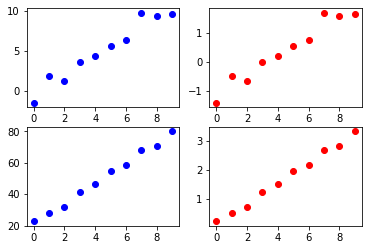

In [5]:
x: np.array = np.vstack([
    np.linspace(0, 10, 10) + np.random.normal(0, 1, 10),
    20 + np.linspace(0, 60, 10) + np.random.normal(0, 1, 10),
])
mean, deviation, y = get_normalized_matrix(x)
assert x.shape == y.shape
print('ORIGINAL', x)
print('NORMALIZED', y)
grid = np.arange(x.shape[1])
figure: Figure = plt.figure()
axes: Axes = figure.add_subplot(2, 2, 1)
axes.plot(grid, x[0].flat, 'o', color='blue')
axes: Axes = figure.add_subplot(2, 2, 2)
axes.plot(grid, y[0].flat, 'o', color='red')
axes: Axes = figure.add_subplot(2, 2, 3)
axes.plot(grid, x[1].flat, 'o', color='blue')
axes: Axes = figure.add_subplot(2, 2, 4)
axes.plot(grid, y[1].flat, 'o', color='red')
plt.show()

## Entropy

- https://en.wikipedia.org/wiki/Entropy_(information_theory)

In information theory, the entropy of a random variable is the average level of "information", "surprise", or "uncertainty" inherent in the variable's possible outcomes.

$$ H(x) = - \sum\limits^{^n}_{i=1} P(x_i) \cdot log P(x_i) $$

In [6]:
def get_entropy_array(matrix: np.array) -> np.array:
    """
    Entropy Matrix.
    """
    P: np.matrix = np.count_nonzero(~np.isnan(matrix.T), axis=1) / matrix.shape[0]
    P[P == 0] = 1
    return np.abs(np.log(P))

In [7]:
X: np.array = np.array([
    [1, np.nan, 3, np.nan, np.nan],
    [4, 5, np.nan, np.nan, np.nan],
    [7, 8, 9, 5, np.nan],
    [7, 8, 9, np.nan, np.nan],
    [7, 8, 9, np.nan, np.nan],
    [7, 8, 9, np.nan, np.nan],
    [7, 8, 9, np.nan, np.nan],
    [1, 2, 2, np.nan, np.nan]
])
E: np.array = get_entropy_array(X)
print(X)
print(E)

[[ 1. nan  3. nan nan]
 [ 4.  5. nan nan nan]
 [ 7.  8.  9.  5. nan]
 [ 7.  8.  9. nan nan]
 [ 7.  8.  9. nan nan]
 [ 7.  8.  9. nan nan]
 [ 7.  8.  9. nan nan]
 [ 1.  2.  2. nan nan]]
[0.         0.13353139 0.13353139 2.07944154 0.        ]


## Cosine Similarity

- https://en.wikipedia.org/wiki/Cosine_similarity

Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space. It is defined to equal the cosine of the angle between them, which is also the same as the inner product of the same vectors normalized to both have length 1.

$$ cos(X, Y) = \frac{X \cdot Y}{ \left \Vert X \right \| \cdot \left \Vert Y \right \| } = \frac{ \sum\limits^{^n}_{i=1} X_i \cdot Y_i }{ \sqrt{\sum\limits^{^n}_{i=1} X_i^2} \cdot \sqrt{\sum\limits^{^n}_{i=1} Y_i^2} } $$

In [8]:
def get_cosine(X: np.array, Y: np.array) -> float:
    """
    Cosine Similarity function.
    """
    union: np.array = ~np.isnan(np.sum([X, Y], axis=0))
    if np.count_nonzero(union) == 0:
        return 0
    discount: float = min(MIN_SHARED_RATINGS, np.count_nonzero(union)) / MIN_SHARED_RATINGS
    return discount * np.sum(X[union] * Y[union]) / \
        (max(0.0000001, np.sqrt(np.sum(np.power(X[union], 2)))) *\
         max(0.0000001, np.sqrt(np.sum(np.power(Y[union], 2)))))

[ 1. nan  2.  3.  4.  5.  6.  7.  8.  9.] [ 1.  3.  2.  2. nan  8.  9. 10. 11. 12.] 0.9929196160911488


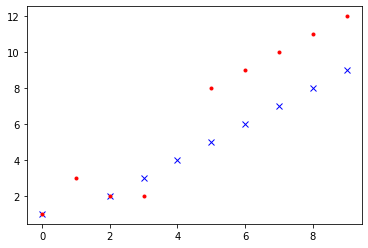

In [9]:
X: np.array = np.array([1, np.nan, 2, 3, 4, 5, 6, 7, 8, 9])
Y: np.array = np.array([1, 3, 2, 2, np.nan, 8, 9, 10, 11, 12])
print(X, Y, get_cosine(X, Y))
figure: Figure = plt.figure()
axes: Axes = figure.add_subplot()
axes.plot(np.arange(X.shape[0]), X, 'x', color='blue')
axes.plot(np.arange(Y.shape[0]), Y, '.', color='red')
plt.show()

[ 1. nan  2.  3.  4.  5.  6.  7.  8.  9.] [ 10.  30.  20.  20.  nan  80.  90. 100. 110. 120.] 0.9929196160911488


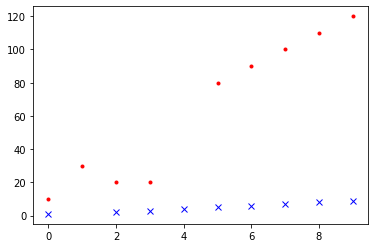

In [10]:
X: np.array = np.array([1, np.nan, 2, 3, 4, 5, 6, 7, 8, 9])
Y: np.array = np.array([10, 30, 20, 20, np.nan, 80, 90, 100, 110, 120])
print(X, Y, get_cosine(X, Y))
figure: Figure = plt.figure()
axes: Axes = figure.add_subplot()
axes.plot(np.arange(X.shape[0]), X, 'x', color='blue')
axes.plot(np.arange(Y.shape[0]), Y, '.', color='red')
plt.show()

[ 1. nan  2.  3.  4.  5.  7.  9. 10.] [100.  65.  32.  24.  nan  10.   7.   4.   2.] 0.21975098781417202


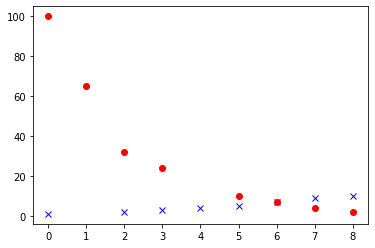

In [11]:
X: np.array = np.array([1, np.nan, 2, 3, 4, 5, 7, 9, 10])
Y: np.array = np.array([100, 65, 32, 24, np.nan, 10, 7, 4, 2])
print(X, Y, get_cosine(X, Y))
figure: Figure = plt.figure()
axes: Axes = figure.add_subplot()
axes.plot(np.arange(X.shape[0]), X, 'x', color='blue')
axes.plot(np.arange(Y.shape[0]), Y, 'o', color='red')
plt.show()

## Similarity Matrix

In [12]:
def get_similarity_matrix(matrix: np.array) -> np.array:
    """
    Get similarity matrix out of a given matrix.
    """
    correlations: np.array = np.stack([
        [
            0 if i >= j else get_cosine(x, y)
            for j, y in enumerate(matrix)
        ]
        for i, x in enumerate(matrix)
    ])
    return correlations + correlations.T

In [13]:
X: np.array = np.array([ [1, 2, 3], [4, 5, 6], [7, 8, 9] ])
S: np.array = get_similarity_matrix(X)
print(X)
print(S)

[[1 2 3]
 [4 5 6]
 [7 8 9]]
[[0.         0.97463185 0.95941195]
 [0.97463185 0.         0.99819089]
 [0.95941195 0.99819089 0.        ]]


## Top K-Similar Rows

- https://en.wikipedia.org/wiki/Adjacency_matrix
- https://numpy.org/doc/stable/reference/generated/numpy.argsort.html

In graph theory and computer science, an adjacency matrix is a square matrix used to represent a finite graph. The elements of the matrix indicate whether pairs of vertices are adjacent or not in the graph.

In [14]:
def get_adjacency_matrix(similar: np.array, k: int = 5) -> np.array:
    """
    Get top k similar rows of a similarity matrix.
    """
    closest: np.array = np.argsort(similar)
    return closest[:, closest.shape[1] - k:]

In [15]:
X: np.array = np.array([ [0, 2, 3, 1], [8, 0, 6, 1], [7, 6, 0, 2], [2, 3, 1, 0] ])
S: np.array = get_adjacency_matrix(X, 2)
print(X)
print(S)

[[0 2 3 1]
 [8 0 6 1]
 [7 6 0 2]
 [2 3 1 0]]
[[1 2]
 [2 0]
 [1 0]
 [0 1]]


### Collaborative Filtering

Filling the collaborative filtering matrix with ratings from similar rows. The predicted value is the weighted sum of the adjacent rows. Values are denormalized so that the approximate user scores. Entropy is applied to promote novelty across recommendations.

$$ \hat{R_{i,j}} = \mu + σ \cdot \frac{ \sum\limits^{^n}_{u=1} w_u \cdot R_{u,j} }{ \sum\limits^{^n}_{u=1} w_u } $$

In [16]:
def get_collaborative_filtering(ratings: np.array, normalized: np.array, mean: np.array, deviation: np.array, entropy: np.array, adjacent: np.array, similarity: np.array) -> np.matrix:
    """
    Collaborative Filtering function.
    """
    for i in range(normalized.shape[0]):
        for j in range(normalized.shape[1]):
            if np.isnan(normalized[i][j]):
                total: float = 0
                weights: float = 0
                for k in adjacent[i]:
                    weight: float = similarity[i][k] * entropy[k]
                    weights += weight
                    total += 0 if np.isnan(normalized[k][j]) else normalized[k][j] * weight
                y_hat: float = mean[i].flat[0] + deviation[i].flat[0] * total / weights
                ratings[i, j] = y_hat
    return ratings

## User-Based Collaborative Filtering

#### User-User Matrix

In [17]:
user_user: np.matrix = np.copy(ratings)
print(user_user.shape)
print(user_user)

(10, 15)
[[ 0. nan nan nan  0.  2. nan  5.  2. nan  5. nan  0.  5.  5.]
 [ 0.  2.  1.  0. nan nan  4.  5. nan  5. nan nan nan  1. nan]
 [ 2. nan  4. nan nan  3. nan  5. nan nan  0. nan nan nan  5.]
 [nan nan  3. nan  0.  2. nan nan  0. nan  5. nan nan nan  2.]
 [nan  5. nan  2.  3. nan nan nan nan nan nan nan  0. nan  1.]
 [nan nan nan nan  0.  0. nan  1. nan  2.  1.  0. nan nan nan]
 [nan nan nan  5. nan  1.  4. nan  0.  2. nan nan  4. nan nan]
 [nan nan  3.  2.  2.  0. nan nan  1.  5.  3. nan  0.  2.  3.]
 [nan  3.  0.  5. nan nan  3. nan nan  2.  1. nan  5.  5. nan]
 [ 3.  1. nan nan nan nan  3. nan  5.  5. nan  1.  1.  2.  3.]]


#### User-User Normalized Matrix

In [18]:
mean, deviation, normalized = get_normalized_matrix(user_user)
print(normalized.shape)
print(normalized)

(10, 15)
[[-1.                 nan         nan         nan -1.         -0.09546597
          nan  1.26133508 -0.09546597         nan  1.26133508         nan
  -1.          1.26133508  1.26133508]
 [-1.          0.00790526 -0.49604737 -1.                 nan         nan
   1.01581052  1.51976315         nan  1.51976315         nan         nan
          nan -0.49604737         nan]
 [ 0.12886504         nan  1.25773008         nan         nan  0.69329756
          nan  1.82216261         nan         nan -1.                 nan
          nan         nan  1.82216261]
 [        nan         nan  0.73205081         nan -1.          0.15470054
          nan         nan -1.                 nan  1.88675135         nan
          nan         nan  0.15470054]
 [        nan  1.90619097         nan  0.16247639  0.74371458         nan
          nan         nan         nan         nan         nan         nan
  -1.                 nan -0.41876181]
 [        nan         nan         nan         nan -1.   

#### User-User Similarity Matrix

In [19]:
similarity: np.array = get_similarity_matrix(normalized)
print(similarity.shape)
print(similarity)

(10, 10)
[[ 0.          0.59418069  0.45780608  0.75325108 -0.1091425   0.63975283
  -0.65713902  0.69684907 -0.01885002  0.12557956]
 [ 0.59418069  0.          0.48217446 -0.33333333 -0.05136606  0.55575027
  -0.08053148  0.49261217 -0.20844342  0.57136495]
 [ 0.45780608  0.48217446  0.         -0.11217472 -0.33333333 -0.16947714
  -0.33333333  0.28892185 -0.30792509  0.50348518]
 [ 0.75325108 -0.33333333 -0.11217472  0.         -0.62408681  0.47831256
   0.56111277  0.51161611 -0.47312441 -0.56495971]
 [-0.1091425  -0.05136606 -0.33333333 -0.62408681  0.         -0.33333333
  -0.28489167  0.43271432 -0.03918111 -0.29556719]
 [ 0.63975283  0.55575027 -0.16947714  0.47831256 -0.33333333  0.
   0.47278741  0.79685841  0.02710295  0.61478529]
 [-0.65713902 -0.08053148 -0.33333333  0.56111277 -0.28489167  0.47278741
   0.          0.06977776  0.95328009 -0.17756358]
 [ 0.69684907  0.49261217  0.28892185  0.51161611  0.43271432  0.79685841
   0.06977776  0.         -0.16756069  0.6478333 ]

#### User-User Adjacency Matrix

In [20]:
adjacent: np.array = get_adjacency_matrix(similarity)
print(adjacent.shape)
print(adjacent)

(10, 5)
[[2 1 5 7 3]
 [2 7 5 9 0]
 [2 7 0 1 9]
 [3 5 7 6 0]
 [0 1 8 4 7]
 [3 1 9 0 7]
 [6 7 5 3 8]
 [1 3 9 0 5]
 [0 8 5 9 6]
 [0 2 1 5 7]]


#### Users Entropy Matrix

In [21]:
entropy: np.array = get_entropy_array(user_user.T)
print(entropy.shape)
print(entropy)

(10,)
[0.51082562 0.62860866 0.91629073 0.91629073 1.09861229 0.91629073
 0.91629073 0.40546511 0.62860866 0.51082562]


#### User-User Collaborative Filtering

In [22]:
recommendations: np.matrix = get_collaborative_filtering(ratings=user_user,
                                                         normalized=normalized,
                                                         mean=mean,
                                                         deviation=deviation,
                                                         similarity=similarity,
                                                         entropy=entropy,
                                                         adjacent=adjacent)
print("BECAUSE YOU ARE FRIEND OF", "\n", adjacent)
print("RECOMMENDATIONS", "\n", recommendations)

BECAUSE YOU ARE FRIEND OF 
 [[2 1 5 7 3]
 [2 7 5 9 0]
 [2 7 0 1 9]
 [3 5 7 6 0]
 [0 1 8 4 7]
 [3 1 9 0 7]
 [6 7 5 3 8]
 [1 3 9 0 5]
 [0 8 5 9 6]
 [0 2 1 5 7]]
RECOMMENDATIONS 
 [[ 0.          2.66944251  3.74907307  2.41737703  0.          2.
   3.023357    5.          2.          4.7810225   5.          2.11557321
   0.          5.          5.        ]
 [ 0.          2.          1.          0.          1.41343393  1.75949823
   4.          5.          2.92789083  5.          2.62472312  1.56214173
   1.56892485  1.          4.17974393]
 [ 2.          3.00672893  4.          2.66472676  2.79933881  3.
   4.27149941  5.          4.23014578  5.79925071  0.          3.00207063
   2.31966497  3.70598739  5.        ]
 [ 1.56853429  2.          3.          3.11853311  0.          2.
   2.70816967  2.71212204  0.          3.46496352  5.          1.50855047
   2.04409227  2.63341289  2.        ]
 [ 4.61279719  5.          8.4834676   2.          3.         -2.46237488
   0.85287037 -1.07202541

## Memory-Based Collaborative Filtering

#### Item-Item Matrix

In [23]:
item_item: np.array = np.copy(ratings.T)
print(item_item.shape)
print(item_item)

(15, 10)
[[ 0.  0.  2. nan nan nan nan nan nan  3.]
 [nan  2. nan nan  5. nan nan nan  3.  1.]
 [nan  1.  4.  3. nan nan nan  3.  0. nan]
 [nan  0. nan nan  2. nan  5.  2.  5. nan]
 [ 0. nan nan  0.  3.  0. nan  2. nan nan]
 [ 2. nan  3.  2. nan  0.  1.  0. nan nan]
 [nan  4. nan nan nan nan  4. nan  3.  3.]
 [ 5.  5.  5. nan nan  1. nan nan nan nan]
 [ 2. nan nan  0. nan nan  0.  1. nan  5.]
 [nan  5. nan nan nan  2.  2.  5.  2.  5.]
 [ 5. nan  0.  5. nan  1. nan  3.  1. nan]
 [nan nan nan nan nan  0. nan nan nan  1.]
 [ 0. nan nan nan  0. nan  4.  0.  5.  1.]
 [ 5.  1. nan nan nan nan nan  2.  5.  2.]
 [ 5. nan  5.  2.  1. nan nan  3. nan  3.]]


#### Item-Item Normalized Matrix

In [24]:
mean, deviation, normalized = get_normalized_matrix(item_item)
print(normalized.shape)
print(normalized)

(15, 10)
[[-1.         -1.          0.53960072         nan         nan         nan
          nan         nan         nan  1.30940108]
 [        nan  0.35224681         nan         nan  2.38061702         nan
          nan         nan  1.02837021 -0.3238766 ]
 [        nan -0.31958618  1.72165527  1.04124145         nan         nan
          nan  1.04124145 -1.                 nan]
 [        nan -1.                 nan         nan  0.03142125         nan
   1.57855312  0.03142125  1.57855312         nan]
 [-1.                 nan         nan -1.          1.37170825 -1.
          nan  0.58113883         nan         nan]
 [ 0.80906807         nan  1.7136021   0.80906807         nan -1.
  -0.09546597 -1.                 nan         nan]
 [        nan  7.                 nan         nan         nan         nan
   7.                 nan  5.          5.        ]
 [ 1.88675135  1.88675135  1.88675135         nan         nan -0.42264973
          nan         nan         nan         nan]
 [ 0.07

#### Item-Item Similarity Matrix

In [25]:
similarity: np.array = get_similarity_matrix(normalized)
print(similarity.shape)
print(similarity)

(15, 15)
[[ 0.         -0.65647077  0.41834583  0.33333333  0.33333333  0.03578814
  -0.02130779 -0.55703493  0.51059307  0.08852545 -0.66425204  0.33333333
   0.11801309 -0.33866044  0.04238048]
 [-0.65647077  0.         -0.66652417  0.27517565  0.33333333  0.
   0.53060368  0.33333333 -0.33333333  0.10871896 -0.33333333 -0.33333333
  -0.15553031  0.79586638 -0.27634653]
 [ 0.41834583 -0.66652417  0.         -0.4437458  -0.17071861  0.56681338
  -0.53424466  0.37745105 -0.6254285   0.27539166  0.18536139  0.
  -0.65384611 -0.54966996  0.93517832]
 [ 0.33333333  0.27517565 -0.4437458   0.          0.61795009 -0.07655077
   0.4402144  -0.33333333 -0.61090089 -0.14809571 -0.45176347  0.
   0.7435642   0.93131324  0.31563145]
 [ 0.33333333  0.33333333 -0.17071861  0.61795009  0.         -0.36085549
   0.         -0.35695905  0.38741486  0.25008757 -0.54361356  0.33333333
  -0.30660657 -0.54090654 -0.47368569]
 [ 0.03578814  0.          0.56681338 -0.07655077 -0.36085549  0.
  -0.33333333 

#### Item-Item Adjacency Matrix

In [26]:
adjacent: np.array = get_adjacency_matrix(similarity)
print(adjacent.shape)
print(adjacent)

(15, 5)
[[ 3  4 11  2  8]
 [ 3  4  7  6 13]
 [ 9  7  0  5 14]
 [ 0  6  4 12 13]
 [ 0  1 11  8  3]
 [11 13  2 14  7]
 [13  3  1 12  9]
 [13  2  9 14  5]
 [ 7 11  9  4  0]
 [11 10  7 14  6]
 [ 7 14 11  9 13]
 [ 7  8 10 14  9]
 [ 5 13  0  6  3]
 [ 6 10  1 14  3]
 [ 5  7  9 13  2]]


#### Items Entropy Matrix

In [27]:
entropy: np.array = get_entropy_array(item_item.T)
print(entropy.shape)
print(entropy)

(15,)
[0.91629073 0.91629073 0.69314718 0.69314718 0.69314718 0.51082562
 0.91629073 0.91629073 0.69314718 0.51082562 0.51082562 1.60943791
 0.51082562 0.69314718 0.51082562]


#### Item-Item Collaborative Filtering

In [28]:
recommendations: np.matrix = get_collaborative_filtering(ratings=item_item,
                                                         normalized=normalized,
                                                         mean=mean,
                                                         deviation=deviation,
                                                         similarity=similarity,
                                                         entropy=entropy,
                                                         adjacent=adjacent)
print("BECAUSE YOU WATCHED", "\n", adjacent)
print("RECOMMENDATIONS", "\n", recommendations)

BECAUSE YOU WATCHED 
 [[ 3  4 11  2  8]
 [ 3  4  7  6 13]
 [ 9  7  0  5 14]
 [ 0  6  4 12 13]
 [ 0  1 11  8  3]
 [11 13  2 14  7]
 [13  3  1 12  9]
 [13  2  9 14  5]
 [ 7 11  9  4  0]
 [11 10  7 14  6]
 [ 7 14 11  9 13]
 [ 7  8 10 14  9]
 [ 5 13  0  6  3]
 [ 6 10  1 14  3]
 [ 5  7  9 13  2]]
RECOMMENDATIONS 
 [[0.         0.         2.         1.02614916 1.50640514 0.64295736
  1.25854737 1.47174492 1.30911861 3.        ]
 [3.95827178 2.         3.23288329 2.55639362 5.         2.4482233
  5.85408272 2.95777945 3.         1.        ]
 [3.68932006 1.         4.         3.         2.06437897 1.8509376
  2.21728219 3.         0.         3.39613215]
 [2.95224047 0.         2.94778271 2.41592334 2.         2.41592334
  5.         2.         5.         4.90523178]
 [0.         0.57051746 1.11304079 0.         3.         0.
  1.2795709  2.         1.67918807 1.8867629 ]
 [2.         1.95816743 3.         2.         1.28369813 0.
  1.         0.         1.38653558 1.77578714]
 [3.56386931 4.  